# Baseline

This part aims to answer the following question: Does the model perform well in the absence of attacks?
The results obtained here serve as a baseline for future comparisons after the adversarial attacks.

#### Classes ID and meaning:

0- Speed limit (20km/h)

1- Speed limit (30km/h)

2- Speed limit (50km/h)

3- Speed limit (60km/h)

4- Speed limit (70km/h)

5- Speed limit (80km/h)

6- End of speed limit (80km/h)

7- Speed limit (100km/h)

8- Speed limit (120km/h)

9- No passing

10- No passing for vehicles over 3.5 metric tons

11- Right-of-way at intersection

12- Priority road

13- Yield

14- Stop

15- No vehicle

16- Vehicles over 3.5 tons prohibited

17- No entry

18- General caution

19- Dangerous curve left

20- Dangerous curve right

21- Double curve

22- Bumpy road

23- Slippery road

24- Road narrows on the right

25- Road work

26- Traffic signals

27- Pedestrians

28- Children crossing

29- Bicycles crossing

30- Beware of ice/snow

31- Wild animals crossing

32- End of all speed and passing limits

33- Turn right ahead

34- Turn left ahead

35- Ahead only

36- Go straight or right

37- Go straight or left

38- Keep right

39- Keep left

40- Roundabout mandatory

41- End of no passing

42- End no passing vehicles over 3.5 tons

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict, Counter
        
DATA_ROOT = "./data_gtsrb"                      
CKPT_PATH = "./checkpoints/resnet101_gtsrb_best.pt"
NUM_CLASSES = 43
IMG_SIZE = 224                                
BATCH_SIZE = 128
NUM_WORKERS = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


In [2]:
# Rebuild same architecture
weights = models.ResNet101_Weights.IMAGENET1K_V2
model = models.resnet101(weights=weights)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

ckpt = torch.load(CKPT_PATH, map_location=device)

# Robust: checkpoint might be {"model_state": ...} or directly a state_dict
state_dict = ckpt["model_state"] if isinstance(ckpt, dict) and "model_state" in ckpt else ckpt
model.load_state_dict(state_dict)

model.to(device).eval()
#print("Checkpoint loaded ✅")

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


100%|██████████| 171M/171M [00:01<00:00, 99.2MB/s] 


FileNotFoundError: [Errno 2] No such file or directory: './checkpoints/resnet101_gtsrb_best.pt'

In [ ]:
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std  = (0.229, 0.224, 0.225)

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

test_set = datasets.GTSRB(root=DATA_ROOT, split="test", download=True, transform=test_tfms)
test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print("Test size:", len(test_set))

Test size: 12630


In [ ]:
viz_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),  
])

viz_test_set = datasets.GTSRB(root=DATA_ROOT, split="test", download=False, transform=viz_tfms)

def get_targets(ds):
    for attr in ["targets", "labels", "_labels"]:
        if hasattr(ds, attr):
            t = getattr(ds, attr)
            try:
                return list(map(int, list(t)))
            except Exception:
                pass

    # fallback: usa _samples (lista de (path, label))
    if hasattr(ds, "_samples"):
        return [int(y) for _, y in ds._samples]

    # último caso (mais lento): lê item por item
    return [int(ds[i][1]) for i in range(len(ds))]

targets = get_targets(viz_test_set)
num_classes = len(set(targets))
print("Unique classes:", num_classes)
print("Min label:", min(targets), "Max label:", max(targets))

Unique classes: 43
Min label: 0 Max label: 42


In [ ]:
counts = Counter(targets)
class_ids = list(range(43))  

print("Classes (IDs):", class_ids)
print("\nCounts per class (test):")
for cid in class_ids:
    print(f"Class {cid:02d}: {counts.get(cid, 0)}")

Classes (IDs): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]

Counts per class (test):
Class 00: 60
Class 01: 720
Class 02: 750
Class 03: 450
Class 04: 660
Class 05: 630
Class 06: 150
Class 07: 450
Class 08: 450
Class 09: 480
Class 10: 660
Class 11: 420
Class 12: 690
Class 13: 720
Class 14: 270
Class 15: 210
Class 16: 150
Class 17: 360
Class 18: 390
Class 19: 60
Class 20: 90
Class 21: 90
Class 22: 120
Class 23: 150
Class 24: 90
Class 25: 480
Class 26: 180
Class 27: 60
Class 28: 150
Class 29: 90
Class 30: 150
Class 31: 270
Class 32: 60
Class 33: 210
Class 34: 120
Class 35: 390
Class 36: 120
Class 37: 60
Class 38: 690
Class 39: 90
Class 40: 90
Class 41: 60
Class 42: 90


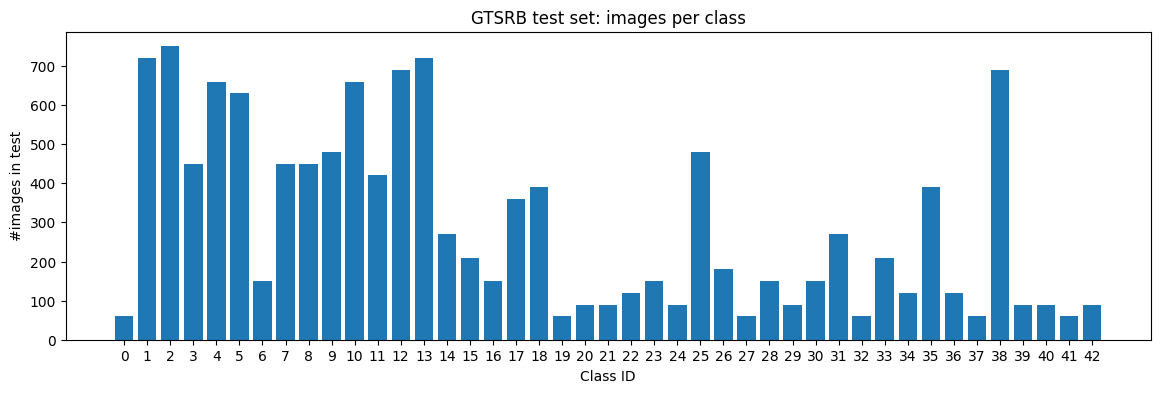

Total: 12630
Min class count: 60 Max class count: 750


In [ ]:
y = [counts.get(cid, 0) for cid in class_ids]

plt.figure(figsize=(14,4))
plt.bar(class_ids, y)
plt.xlabel("Class ID")
plt.ylabel("#images in test")
plt.title("GTSRB test set: images per class")
plt.xticks(class_ids)
plt.show()

print("Total:", sum(y))
print("Min class count:", min(y), "Max class count:", max(y))

In [ ]:
class_to_indices = defaultdict(list)
for idx, cid in enumerate(targets):
    class_to_indices[cid].append(idx)

sorted_by_count = sorted(class_ids, key=lambda c: counts.get(c, 0))
bottom5 = sorted_by_count[:5]
top5 = sorted_by_count[-5:][::-1]

print("Bottom 5 (least images):", bottom5, [counts[c] for c in bottom5])
print("Top 5 (most images):", top5, [counts[c] for c in top5])

Bottom 5 (least images): [0, 19, 27, 32, 37] [60, 60, 60, 60, 60]
Top 5 (most images): [2, 13, 1, 38, 12] [750, 720, 720, 690, 690]


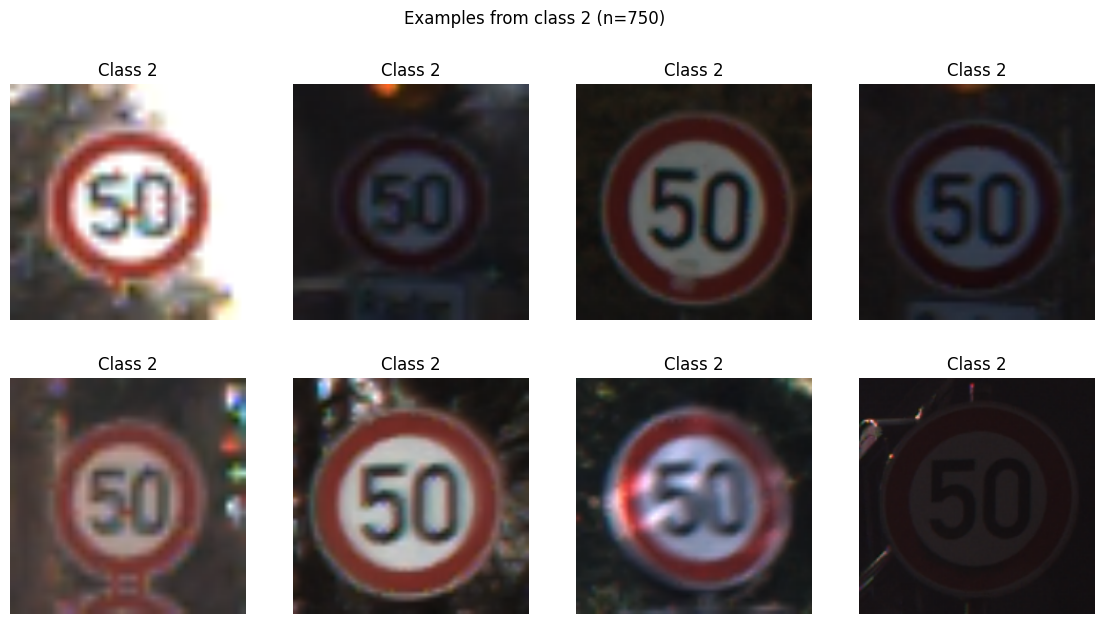

In [ ]:
def show_examples_for_class(ds, class_id, n=8, seed=0):
    random.seed(seed)
    idxs = class_to_indices[class_id]
    if len(idxs) == 0:
        print(f"No images for class {class_id}")
        return
    
    pick = random.sample(idxs, k=min(n, len(idxs)))
    imgs = [ds[i][0] for i in pick]

    cols = min(4, len(imgs))
    rows = int(np.ceil(len(imgs)/cols))

    plt.figure(figsize=(3.5*cols, 3.5*rows))
    for j, img in enumerate(imgs):
        plt.subplot(rows, cols, j+1)
        plt.imshow(img.permute(1,2,0).clamp(0,1))
        plt.axis("off")
        plt.title(f"Class {class_id}")
    plt.suptitle(f"Examples from class {class_id} (n={counts[class_id]})")
    plt.show()

show_examples_for_class(viz_test_set, class_id=top5[0], n=8, seed=1)


In [ ]:
# Rebuild same architecture
weights = models.ResNet101_Weights.IMAGENET1K_V2
model = models.resnet101(weights=weights)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

ckpt = torch.load(CKPT_PATH, map_location=device)

# Robust: checkpoint might be {"model_state": ...} or directly a state_dict
state_dict = ckpt["model_state"] if isinstance(ckpt, dict) and "model_state" in ckpt else ckpt
model.load_state_dict(state_dict)

model.to(device).eval()
#print("Checkpoint loaded ✅")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
confmat = torch.zeros(NUM_CLASSES, NUM_CLASSES, dtype=torch.long)
correct = 0
total = 0

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        preds = logits.argmax(dim=1)

        correct += (preds == y).sum().item()
        total += y.size(0)

        # update confusion matrix
        for t, p in zip(y.view(-1), preds.view(-1)):
            confmat[t.long(), p.long()] += 1

acc = correct / total
print(f"Overall Test Accuracy: {acc*100:.2f}% ({correct}/{total})")


Overall Test Accuracy: 98.87% (12487/12630)


In [ ]:
per_class_total = confmat.sum(dim=1)                 # true counts
per_class_correct = confmat.diag()
per_class_acc = (per_class_correct.float() / per_class_total.clamp(min=1).float())

# Sort classes by accuracy
sorted_idx = torch.argsort(per_class_acc)

print("Worst 10 classes:")
for i in sorted_idx[:10].tolist():
    print(f"Class {i:02d}: acc={per_class_acc[i].item()*100:6.2f}%  (n={per_class_total[i].item()})")

print("\nBest 10 classes:")
for i in sorted_idx[-10:].flip(0).tolist():
    print(f"Class {i:02d}: acc={per_class_acc[i].item()*100:6.2f}%  (n={per_class_total[i].item()})")

Worst 10 classes:
Class 22: acc= 81.67%  (n=120)
Class 42: acc= 93.33%  (n=90)
Class 18: acc= 95.13%  (n=390)
Class 11: acc= 96.43%  (n=420)
Class 40: acc= 96.67%  (n=90)
Class 30: acc= 96.67%  (n=150)
Class 12: acc= 97.10%  (n=690)
Class 39: acc= 97.78%  (n=90)
Class 35: acc= 98.21%  (n=390)
Class 41: acc= 98.33%  (n=60)

Best 10 classes:
Class 17: acc=100.00%  (n=360)
Class 19: acc=100.00%  (n=60)
Class 20: acc=100.00%  (n=90)
Class 00: acc=100.00%  (n=60)
Class 14: acc=100.00%  (n=270)
Class 23: acc=100.00%  (n=150)
Class 27: acc=100.00%  (n=60)
Class 28: acc=100.00%  (n=150)
Class 09: acc=100.00%  (n=480)
Class 32: acc=100.00%  (n=60)


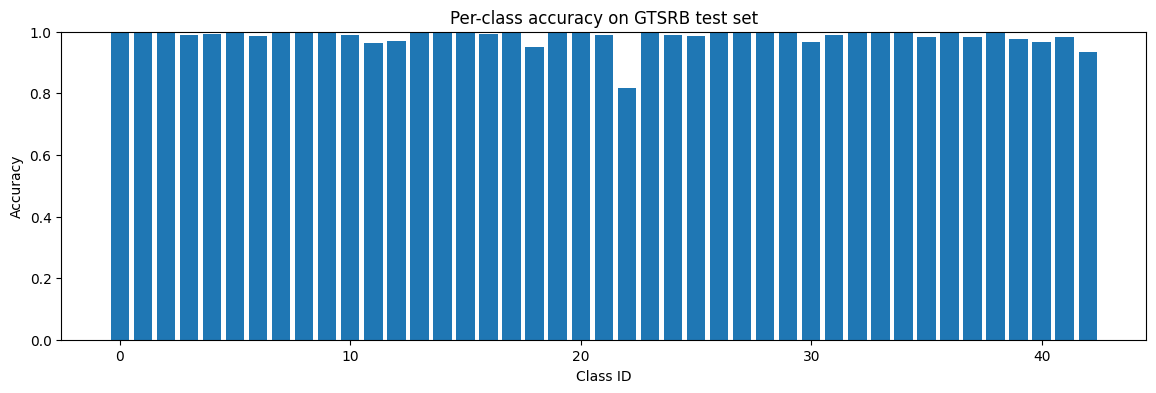

In [ ]:
plt.figure(figsize=(14,4))
plt.bar(range(NUM_CLASSES), per_class_acc.cpu().numpy())
plt.ylim(0, 1.0)
plt.xlabel("Class ID")
plt.ylabel("Accuracy")
plt.title("Per-class accuracy on GTSRB test set")
plt.show()

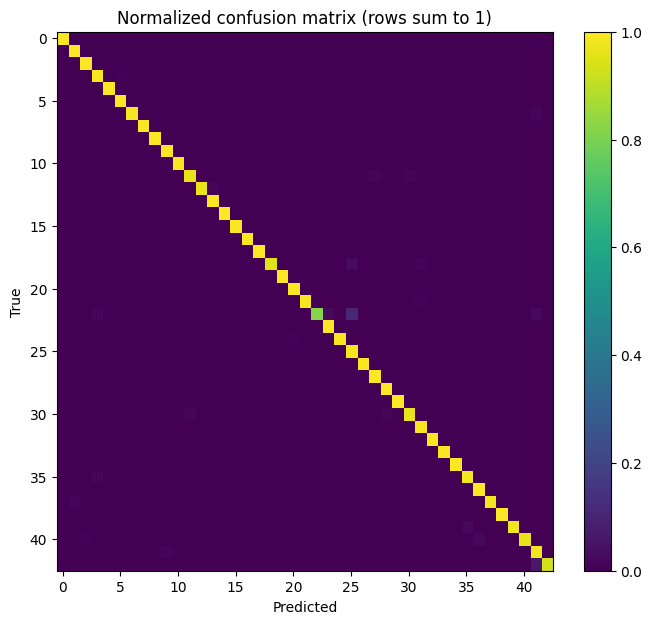

In [ ]:
confmat_norm = confmat.float() / confmat.sum(dim=1, keepdim=True).clamp(min=1).float()

plt.figure(figsize=(8,7))
plt.imshow(confmat_norm.cpu().numpy(), aspect="auto")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized confusion matrix (rows sum to 1)")
plt.show()

In [ ]:
# zero out diagonal so we only see mistakes
cm = confmat.clone()
cm.fill_diagonal_(0)

# get top confusions
flat = cm.flatten()
topk = torch.topk(flat, k=15)
indices = topk.indices.tolist()
values = topk.values.tolist()

print("Top confusions (true -> predicted : count):")
for idx, val in zip(indices, values):
    true = idx // NUM_CLASSES
    pred = idx % NUM_CLASSES
    print(f"{true:02d} -> {pred:02d} : {val}")

Top confusions (true -> predicted : count):
22 -> 25 : 14
12 -> 13 : 13
18 -> 25 : 11
11 -> 30 : 8
18 -> 31 : 7
10 -> 09 : 7
42 -> 41 : 6
35 -> 03 : 5
11 -> 27 : 5
03 -> 05 : 4
12 -> 29 : 4
25 -> 11 : 3
22 -> 41 : 3
22 -> 23 : 3
04 -> 02 : 3


In [ ]:
from attacks.adv_patch_pgd import TargetedAdversarialPatchPGD

STOP_CLASS = 14   # ⚠️ confirm STOP index in your dataset

patch_attack = TargetedAdversarialPatchPGD(
    model=ckpt,
    target_class=STOP_CLASS,
    patch_size=40,
    steps=300
)

images, _ = next(iter(train_loader))
images = images.cuda()

patch = patch_attack.generate(images)
torch.save(patch, "patch_stop.pt")


ModuleNotFoundError: No module named 'attacks'

In [ ]:
from data.generate_patched_gtsrb import generate_dataset

patch = torch.load("patch_stop.pt").cuda()

patched_images, patch_masks = generate_dataset(
    train_loader,
    patch,
    device="cuda"
)

torch.save(patched_images, "patched_images.pt")
torch.save(patch_masks, "patch_masks.pt")
